In [1]:
import torch
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
import numpy as np
from collections import deque
import socketio
import queue
import threading
import os
import json
from numba import jit, prange
from numba.typed import List

# Interactive Hologram

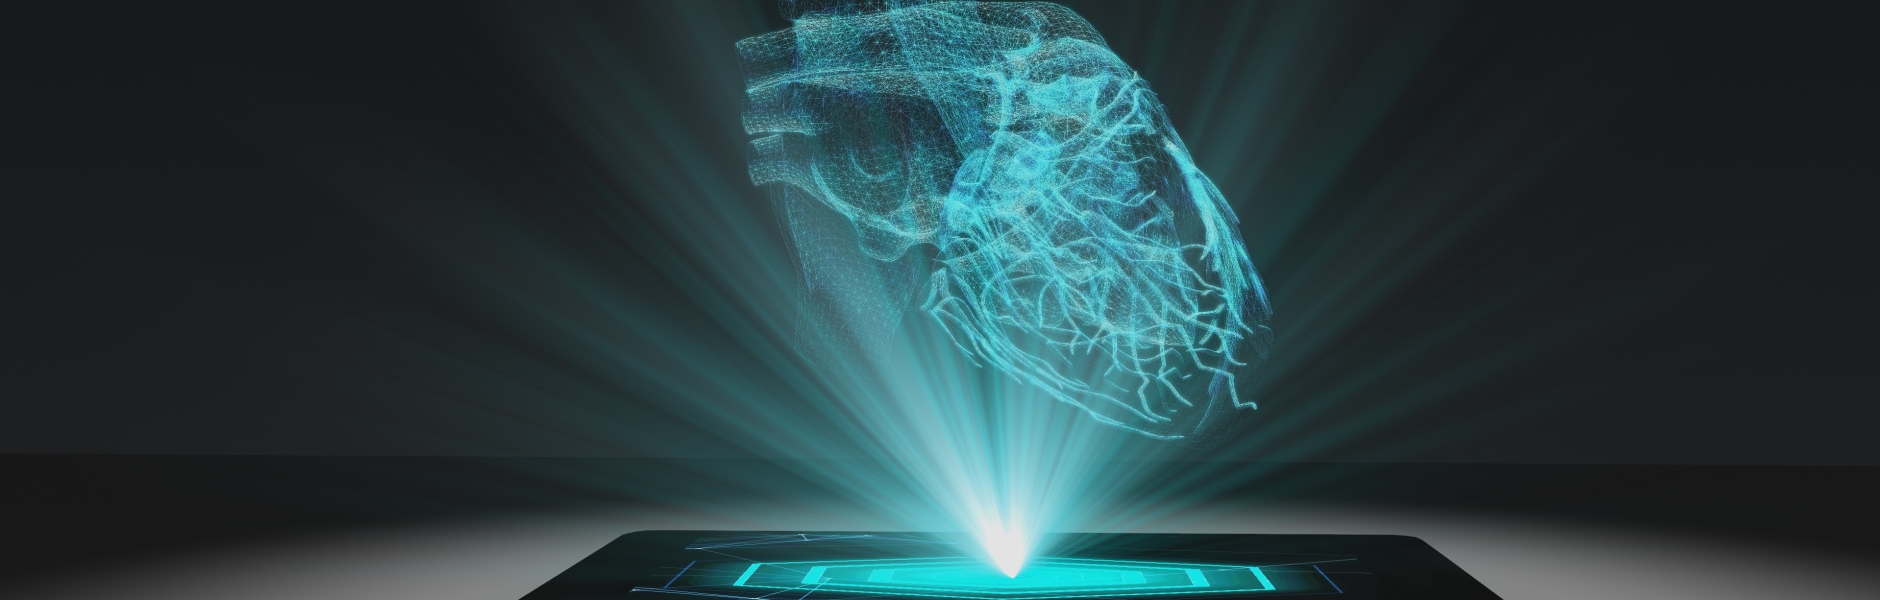

Holograms have been a dream of tech and entertainment companies as well as consumers ever since a long time. The real hologram can be seen without the aid of any special lenses,screens or props. But there are holographic images produced by means of lenses to create stage illusions like Pepper’s Ghost which are not true holograms, they are called holographic illusions. We will be using Pepper’s Ghost Pyramid to create our holographic illusion.

The DIY hologram pyramid is a simple device that can be made by manipulating a sheet of plastic into the shape of a pyramid with its top cut off. The device creates a 3D-like illusion for the viewer and makes an image or video appear as if it were in midair.

### Objective

The objective of the project is to make use of the key points of the hand generated by the SRHandNET model to create a new model which will recognise the hand gestures from the key points. Using these gestures we will assign different actions to the which will be used to manipulate the 3D objects in our hologram. 

# Stage 1 (SRHandNet)

- Gesture recognition for human computer interaction is an area of active research in computer vision and machine learning.
- The primary goal of gesture recognition research is to create a system, which can identify specific human gestures and use them to convey information or for device control.
- These gestures may either be still or moving.

### SRHandNET is a machine learning model for real-time 2D hand pose estimation. 


In [2]:
# colors for 21 points on the hand
HAND_POINT_COLORS = [
    (100, 100, 100), (100, 0, 0), (150, 0, 0), (200, 0, 0), (255, 0, 0),
    (100, 100, 0), (150, 150, 0), (200, 200, 0), (255, 255, 0), (0, 100, 50),
    (0, 150, 75), (0, 200, 100), (0, 255, 125), (0, 50, 100), (0, 75, 150),
    (0, 100, 200), (0, 125, 255), (100, 0, 100), (150, 0, 150), (200, 0, 200),
    (255, 0, 255),
]
TRAIN_IMAGE_HEIGHT = 256
TRAIN_IMAGE_WIDTH = 256

In [3]:
@jit(nopython=True, cache=True)
def is_local_value_great(src, locval, temploc):
    blockwidth=2
    startout = max(temploc[0] - blockwidth, 0)
    endout = min(temploc[0] + blockwidth, src.shape[1] - 1) + 1
    startin = max(temploc[1] - blockwidth, 0)
    endin = min(temploc[1] + blockwidth, src.shape[0] - 1) + 1
    
    for m in prange(startout, endout):
        for n in prange(startin, endin):
            if float(src[n, m]) > locval:
                return False
    return True

In [4]:
@jit(nopython=True, parallel=True, cache=True)
def get_locations(src, threshold):
    location = List()
    blockwidth=2

    endout = src.shape[1] - blockwidth
    endin = src.shape[0] - blockwidth
    
    for i in prange(blockwidth, endout):
        for j in prange(blockwidth, endin):
            tmploc = (i, j)
            localvalue = float(src[j, i])
            
            if localvalue < threshold:
                continue
                
            localmaximum = is_local_value_great(src, localvalue, tmploc)
            
            if localmaximum:
                location.append((localvalue, np.array(tmploc)))
                
    return location

In [5]:
@jit(cache=True, forceobj=True, nopython=True)
def transform_input(input_tensor, src_img, tensor_index=0):
    ratio = min(
        input_tensor.shape[2] / src_img.shape[0],
        input_tensor.shape[3] / src_img.shape[1]
    )
    M = np.float32([[ratio, 0, 0], [0, ratio, 0]])
    dst = cv2.warpAffine(src_img, M, (input_tensor.size(3), input_tensor.size(2)), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_CONSTANT, borderValue=128)
    
    dst = dst / 255.0 - 0.5
    chn_img = cv2.split(dst)
    
    if len(chn_img) == 1:
        input_tensor[tensor_index][0] = torch.from_numpy(chn_img[0])
        input_tensor[tensor_index][1] = torch.from_numpy(chn_img[0])
        input_tensor[tensor_index][2] = torch.from_numpy(chn_img[0])
    else:
        input_tensor[tensor_index][0] = torch.from_numpy(chn_img[0])
        input_tensor[tensor_index][1] = torch.from_numpy(chn_img[1])
        input_tensor[tensor_index][2] = torch.from_numpy(chn_img[2])
    return ratio

In [6]:
def detect_bounding_box(boxes, model, input_image):
    input_tensor = torch.zeros(1, 3, TRAIN_IMAGE_HEIGHT, TRAIN_IMAGE_WIDTH)
    
    ratio_input_to_net = transform_input(input_tensor, input_image)
    
    heatmap = model.forward(input_tensor.cuda())[3]
    ratio_net_downsample = TRAIN_IMAGE_HEIGHT / heatmap.size(2)
    rect_map_idx = heatmap.size(1) - 3
    rectmap = [None] * 3
    
    for i in range(3):
        rectmap[i] = heatmap[0][i + rect_map_idx].cpu().detach().numpy()
    
    locations = get_locations(rectmap[0], HAND_THRESHOLD)

    boxes.clear()
    
    for i in locations:
        points = i[1]
        pos_x = points[0]
        pos_y = points[1]
        
        ratio_width = 0.0
        ratio_height = 0.0
        pixelcount = 0
        
        for m in range(max(pos_y - 2, 0), min(pos_y + 3, heatmap.size(2))):
            for n in range(max(pos_x - 2, 0), min(pos_x + 3, heatmap.size(3))):
                ratio_width += float(rectmap[1][m, n])
                ratio_height += float(rectmap[2][m, n])
                pixelcount += 1
                
        if pixelcount > 0:
            ratio_width = min(max(ratio_width/pixelcount, 0.0), 1.0)
            ratio_height = min(max(ratio_height/pixelcount, 0.0), 1.0)
            
            points = points * ratio_net_downsample / ratio_input_to_net
            rect_w = ratio_width * TRAIN_IMAGE_WIDTH / ratio_input_to_net
            rect_h = ratio_height * TRAIN_IMAGE_HEIGHT / ratio_input_to_net
            
            lt = (points - np.array([rect_w//2, rect_h//2])).astype('int32')
            rb = (points + np.array([rect_w//2, rect_h//2])).astype('int32')
            lt[0] = max(lt[0], 0)
            lt[1] = max(lt[1], 0)
            rb[0] = min(rb[0], input_image.shape[1]-1)
            rb[1] = min(rb[1], input_image.shape[0]-1)
            boxes.append((lt[0], lt[1], rb[0]-lt[0], rb[1]-lt[1]))

In [7]:
def detect_hand_points(manypoints, model, input_image, boxes, locs, rects):
    input_tensor = torch.zeros(len(boxes), 3, TRAIN_IMAGE_HEIGHT, TRAIN_IMAGE_WIDTH)
    ratio_input_to_net = [None]*len(boxes)
    for i in range(len(boxes)):
        a = int(boxes[i][0])
        b = a + int(boxes[i][2])
        c = int(boxes[i][1])
        d = c + int(boxes[i][3])
        sliced = input_image[c:d, a:b]
        ratio_input_to_net[i] = transform_input(input_tensor, sliced, i)
    
    net_result = model.forward(input_tensor.cuda())[3]
    ratio_net_downsample = TRAIN_IMAGE_HEIGHT / net_result.size(2)
    
    if len(boxes) == 2:
        rects.clear()
    
    for rect_idx in range(len(boxes)):
        rect = []
        for i in range(net_result.size(1) - 3):
            heatmap = net_result[rect_idx][i].cpu().detach().numpy()
            pts = get_locations(heatmap, FINGER_THRESHOLD)

            count = 0
            for j in pts:
                if count >= 1:
                    break
                temp = j[1]
                
                if count == 0:
                    locs[i] = j[1].copy()
                
                temp = temp*ratio_net_downsample/ratio_input_to_net[rect_idx]
                temp = temp + np.array([boxes[rect_idx][0], boxes[rect_idx][1]])
                manypoints[i].append((j[0], temp))
                rect.append(temp.copy())
                count += 1
                
        rects.append(rect)

In [8]:
@jit(forceobj=True)
def detect_box_and_hand(model, input_image):
    center = np.array([0, 0])
    rects = []
    boxes = []
    locs = [None]*21

    many_keypoints = [[] for _ in range(21)]

    boxes.append((0, 0, input_image.shape[1], input_image.shape[0]))
    detect_bounding_box(boxes, model, input_image)

    if len(boxes) == 0:
        return (locs, [], None)

    thickness_circle_ratio = 1 / 120
    thickness_circle = max(int(math.sqrt(input_image.shape[1] * input_image.shape[0]) * thickness_circle_ratio + 0.5), 2)
    number_colors = len(HAND_POINT_COLORS)
    
    detect_hand_points(many_keypoints, model, input_image, boxes, locs, rects)
    count = 0
    for curr_joint_index in range(0, 21):
        curr_color = HAND_POINT_COLORS[curr_joint_index % number_colors]
        
        for i in many_keypoints[curr_joint_index]:
            center = center + i[1]
            count += 1
            cv2.circle(input_image, (int(i[1][0]), int(i[1][1])), thickness_circle, curr_color, -1)
#             cv2.putText(input_image, str(curr_joint_index), (int(i[1][0]), int(i[1][1])), cv2.FONT_HERSHEY_SIMPLEX, 0.25, (0, 0, 255), 1)
    
    if count != 0:
        center = center / count
#         cv2.circle(input_image, (int(centers[0]), int(centers[1])), thickness_circle, (0, 0, 0), -1)
        
    for i in boxes:
        cv2.rectangle(input_image, i, (0, 255, 0), thickness=int(min(input_image.shape[1] / TRAIN_IMAGE_WIDTH * 3.0, 3.0)))

    return (locs, rects, center)

In [9]:
def clean_points(points):
    temp = [20, 16, 12, 8, 17, 13, 9, 5]
    for i in range(len(temp)):
        if points[temp[i]] is None:
            points[temp[i]] = points[temp[(i+4)%8]]

In [10]:
model_1 = torch.jit.load('hand.pts', map_location=torch.device('cuda'))

In [26]:

HAND_THRESHOLD = 0.8
FINGER_THRESHOLD = 0.2

capture = cv2.VideoCapture(0)

while True:

    ret, frame = capture.read()
    
    if frame is None:
        print("Cannot open camera")
        cv2.destroyAllWindows()
        break

    t = cv2.getTickCount()

    try:
        points, rects, center  = detect_box_and_hand(model_1, frame)
    except OverflowError:
        print('overflow error')
        continue

    t = (cv2.getTickCount() - t) / cv2.getTickFrequency()
    fps = 1.0 / t
    
    cv2.putText(frame, "FPS: {}".format(round(fps, 2)), (frame.shape[1] - 200, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
    cv2.putText(frame, "PTS: {}".format(no_of_pts), (frame.shape[1] - 200, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
    cv2.imshow('hand detection', frame)
    
    
    if cv2.waitKey(1) == 27:
        cv2.destroyAllWindows()
        break

capture.release()
cv2.destroyAllWindows()


In [11]:
labels = [
    '1_finger',
    '2_finger',
    '3_finger',
    '4_finger',
    '5_finger',
    'okay',
    'thumbs_up',
    'thumbs_down',
    'call',
]

In [12]:
sio1 = socketio.Client()

@sio1.event
def connect():
    print('connection established')
    sio1.emit('model')

@sio1.event
def disconnect():
    print('disconnected from server')
    
@sio1.event
def predictions(data):
    global prediction
    prediction = np.array(data['preds'])

# run cell only if sio_server.py is running

In [30]:
plt.ion()
%matplotlib qt

model_2_input = None
prediction = None
payload = {}

gestures_history = deque(maxlen=5)
centers_history = deque(maxlen=10)
distances_history = deque(maxlen=2)
mode = 0

HAND_THRESHOLD = 0.8
FINGER_THRESHOLD = 0.2

capture = cv2.VideoCapture(0)

sio1.connect('http://127.0.0.1:8080')
while True:

    ret, frame = capture.read()
    
    if frame is None:
        print("Cannot open camera")
        cv2.destroyAllWindows()
        break

    t = cv2.getTickCount()

    try:
        points, rects, center  = detect_box_and_hand(model_1, frame)
    except OverflowError:
        print('overflow error')
        continue
    
    no_of_pts = len([i for i in points if i is not None])
    
    
    # if no. of points detected are enough, add input for model2 to payload
    if 21-no_of_pts < 5:
        clean_points(points)
        if 21-no_of_pts == 0:
            model2_input = np.array(points).flatten()
            payload.update({'m2': model2_input.tolist()})
        else:
            for i in range(len(points)):
                if points[i] is None:
                    points[i] = np.mean([j for j in points if j is not None], axis=0)
            model2_input = np.array(points).flatten()
            payload.update({'m2': model2_input.tolist()})
    
    # if two bounding boxes exist, add distances between their centers to distance history
    # else clear distance history
    if len(rects) == 2:
        if len(distances_history) == 2:
            distances_history.append(np.linalg.norm(
                np.mean(rects[0], axis=0) - np.mean(rects[1], axis=0)
            ))
            z = round(distances_history[-1]-distances_history[-2], 2)
            payload.update({'z': float(z)})
        else:
            distances_history.append(np.linalg.norm(
                np.mean(rects[0], axis=0) - np.mean(rects[1], axis=0)
            ))
    else:
        distances_history.clear()
    
        
    # add current center to history if it is not None, if none clear history
    if center is not None:
        centers_history.append(center)
        
        # add difference between centers to payload if current center is detected
        if len(centers_history) >= 2 and center is not None:        
            c = centers_history[-1]-centers_history[-2]
            c[0] = round(c[0], 1)
            c[1] = round(c[1], 1)

            payload.update({'x': float(c[0]), 'y': float(c[1])})

    else:
        centers_history.clear()
                     
    # add current prediction to payload for stone paper sicssors, plot prediction graph
    if prediction is not None:
        payload.update({'pred': labels[np.argmax(prediction[0])]})
        plt.cla()
        plt.bar(labels, prediction[0], 0.2)
        plt.ylim([0, 1])
        plt.draw()

    
    # change current mode based on past gesture, clear gesture history if no gesture is detected
    if prediction is not None and prediction[0].max() > 0.4:
        label = labels[np.argmax(prediction[0])]

        gestures_history.append(label)
        if len(gestures_history) == 5 and len(set(gestures_history)) == 1:
            if label == 'okay':
                mode = 0
            elif label == '5_finger':
                pass
            elif label == '1_finger':
                mode = 1
            elif label == '2_finger':
                mode = 2
            elif label == '3_finger':
                mode = 3
            elif label == '4_finger':
                mode = 4
            elif label == 'thumbs_up':
                mode = 8
            elif label == 'thumbs_down':
                mode = 9

        cv2.putText(frame, label, (frame.shape[1]-500, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 1)
        prediction = None
    else:
        gestures_history.clear()
            
    # calculate fps
    t = (cv2.getTickCount() - t) / cv2.getTickFrequency()
    fps = 1.0 / t
    
    cv2.putText(frame, "FPS: {}".format(round(fps, 2)), (frame.shape[1] - 200, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
    cv2.putText(frame, "PTS: {}".format(no_of_pts), (frame.shape[1] - 200, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
    cv2.imshow('hand detection', frame)
    
    # send payload to server
    payload.update({'mode': mode})
    sio1.emit('transmit', payload)
    payload.clear()
    
    if cv2.waitKey(1) == 27:
        cv2.destroyAllWindows()
        break

capture.release()
plt.close()
cv2.destroyAllWindows()
sio1.disconnect()

connection established


In [28]:
sio1.disconnect()

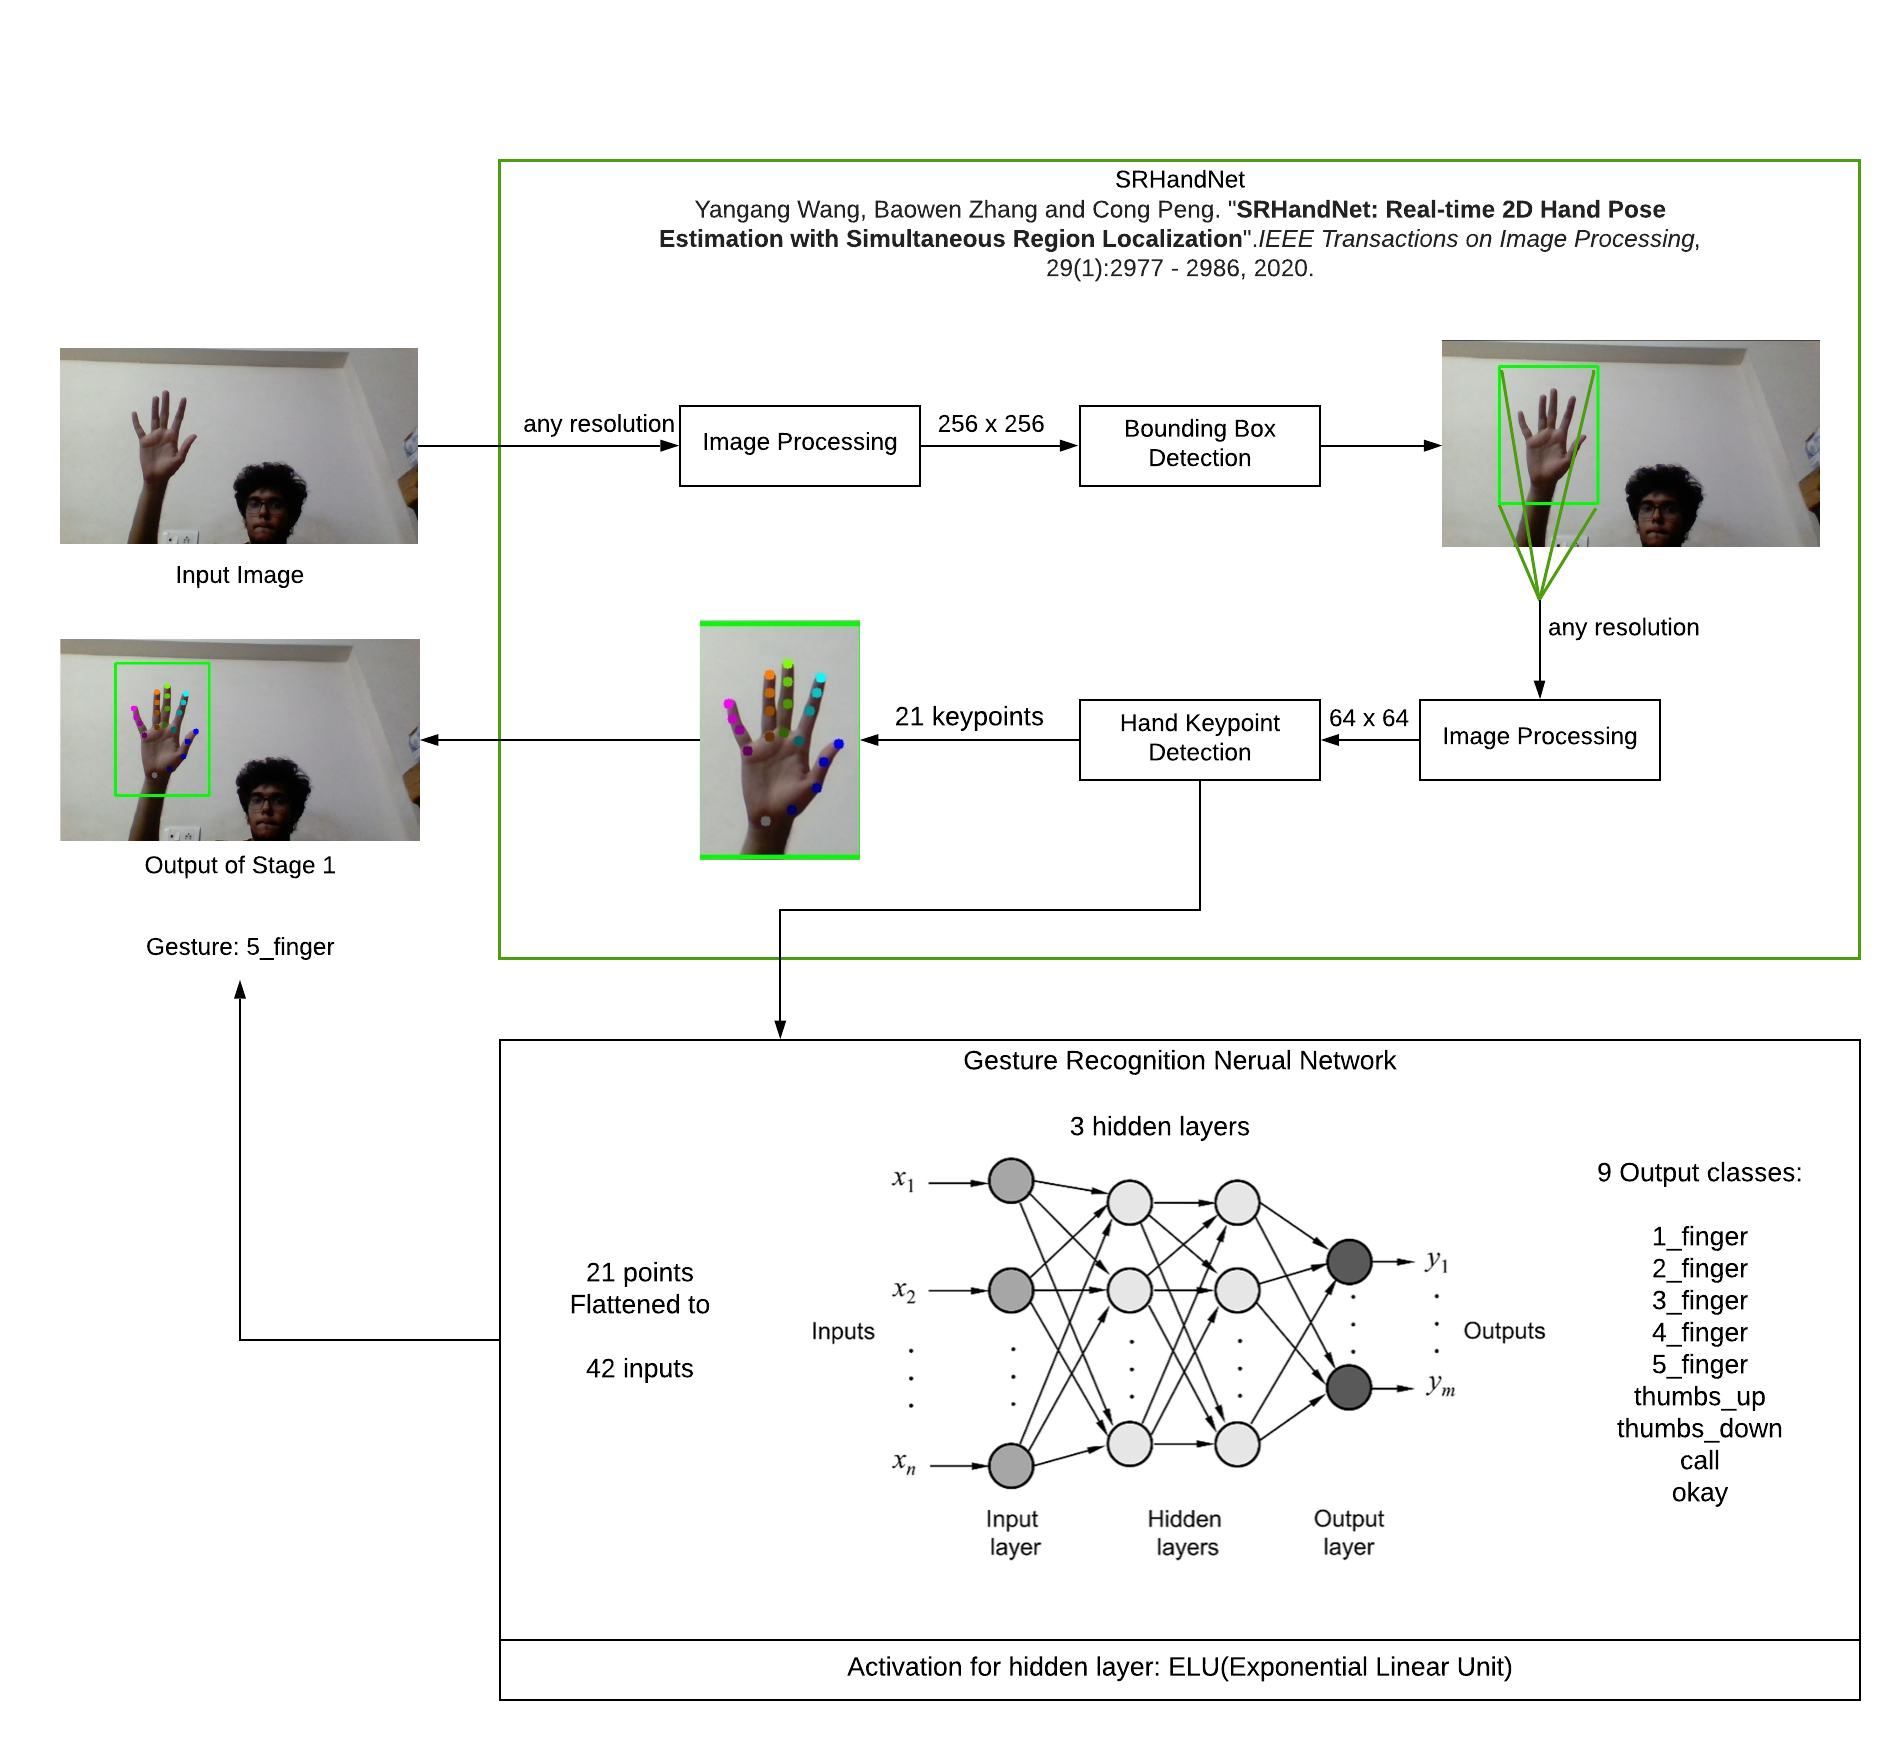